# Task 2 - clustering and differential expression

In [29]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats as stats

from statsmodels.stats.multitest import fdrcorrection

In [2]:
adata = sc.read('task1_rna_output_linear.h5ad')

In [4]:
sc.tl.leiden(adata)


In [5]:
labels = pd.read_csv('annotation_levels.csv')

In [6]:
coarse_cts = labels['Coarse_annotation_levels'].drop_duplicates().tolist()

In [8]:
len(coarse_cts)

12

/home/ssm-user/miniconda3/envs/single_cell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


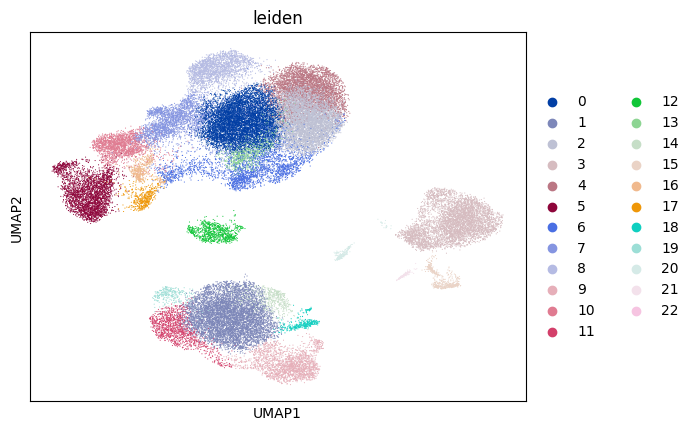

In [9]:
sc.pl.umap(adata, color='leiden')

In [10]:
adata.write('task2_leiden.h5ad')

### Select genes for differential expression

In [11]:
clusters = adata.obs['leiden'].drop_duplicates().tolist()

In [12]:
expressed_genes = []

# For each cluster
for c in clusters:

    # Select cells ct_cells is now a 2d numpy matrix
    ct_cells = adata[adata.obs['leiden'] == c].raw.X.toarray()

    # For each gene, what % of cells have non-zero count
    perc_expr = (ct_cells > 0).mean(axis=0)

    # Is that % we calculated greater than 0.1
    expressed_genes.append( perc_expr > 0.1 )

expressed_genes = np.vstack(expressed_genes).astype(int)

# results in 0 if no cluster expressed that gene over 10% of cells, 1 otherwise
pass_genes = expressed_genes.max(axis=0).astype(bool)

In [13]:
pass_genes.shape

(16524,)

In [14]:
adata.shape

(48518, 1700)

In [45]:
all_results = []
for c in clusters:

    # Select ct and rest cells
    ct_cells = adata.raw[adata.obs['leiden'] == c, pass_genes].X.toarray()
    rest_cells = adata.raw[adata.obs['leiden'] != c, pass_genes].X.toarray()

    # Undo the log1p transformation to get back "raw" "raw" normalized counts that sum to 10K
    ct_cells = np.exp(ct_cells)-1
    rest_cells = np.exp(rest_cells)-1

    # Compute the log fold change across cells (rows)
    lfc = np.log2( ct_cells.mean(axis=0) / rest_cells.mean(axis=0) )

    # Calculate the Wilcoxon rank sum test for each gene
    _, pvalue = stats.ranksums(ct_cells, rest_cells)
    _, fdr = fdrcorrection(pvalue)

    result_df = pd.DataFrame(
        zip(lfc, pvalue, fdr),
        index=adata.raw.var.index[pass_genes].tolist(),
        columns=['log2_FC', 'pvalue', 'fdr'])
    result_df['cluster'] = c

    result_df = result_df\
        .query('fdr < 0.01')\
        .sort_values('log2_FC', ascending=False)\
        .head(100)

    all_results.append(result_df)

/tmp/ipykernel_315087/2850900857.py:13: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2( ct_cells.mean(axis=0) / rest_cells.mean(axis=0) )
/tmp/ipykernel_315087/2850900857.py:13: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2( ct_cells.mean(axis=0) / rest_cells.mean(axis=0) )
/tmp/ipykernel_315087/2850900857.py:13: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2( ct_cells.mean(axis=0) / rest_cells.mean(axis=0) )
/tmp/ipykernel_315087/2850900857.py:13: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2( ct_cells.mean(axis=0) / rest_cells.mean(axis=0) )
/tmp/ipykernel_315087/2850900857.py:13: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2( ct_cells.mean(axis=0) / rest_cells.mean(axis=0) )
/tmp/ipykernel_315087/2850900857.py:13: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2( ct_cells.mean(axis=0) / rest_cells.mean(axis=0) )
/tmp/ipykernel_315087/2850900857.py:13: RuntimeWarni

In [46]:
all_results_df = pd.concat(all_results)

### Format the output

In [57]:
formatted = all_results_df\
    .reset_index()\
    .rename(columns={'index':'gene', 'log2_FC':'avg_log2FC', 'pvalue':'p_val'})

In [61]:
formatted[['cluster', 'gene', 'avg_log2FC', 'p_val']].to_csv('task2_markers.csv')